In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import ipaddress

##### Load the datasets

In [2]:
fraud_data = pd.read_csv('/home/semre/fraud_detection_data_analysis/data/Fraud_Data.csv')
ip_data = pd.read_csv('/home/semre/fraud_detection_data_analysis/data/IpAddress_to_Country.csv')
creditcard_data = pd.read_csv('/home/semre/fraud_detection_data_analysis/data/creditcard.csv')

### Data Analysis and Preprocessing

#### 1. Handle Missing Values

In [3]:
# Check for missing values
fraud_data.isnull().sum()
ip_data.isnull().sum()
creditcard_data.isnull().sum()

# Dropping rows with missing 'purchase_value' for example
fraud_data.dropna(subset=['purchase_value'], inplace=True)

# Impute missing values for 'age' with median
fraud_data['age'].fillna(fraud_data['age'].median(), inplace=True)

/tmp/ipykernel_10344/2559722447.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fraud_data['age'].fillna(fraud_data['age'].median(), inplace=True)


#### 2. Data Cleaning

##### Remove duplicates

In [4]:
fraud_data.drop_duplicates(inplace=True)
creditcard_data.drop_duplicates(inplace=True)

##### Correct data types

In [5]:
# Convert signup_time and purchase_time to datetime
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Ensure 'ip_address' is a string
fraud_data['ip_address'] = fraud_data['ip_address'].astype(str)

##### Convert IP to integers in fraud_data

In [7]:
# Function to safely convert IP addresses to integer format
def convert_to_ip(x):
    try:
        # If it's a float, convert to integer first
        if isinstance(x, float):
            x = int(x)
        # Convert the integer back to IPv4 address format
        return int(ipaddress.IPv4Address(x))
    except ValueError:
        # Handle invalid IP addresses by returning NaN
        return np.nan

# Apply the function to the 'ip_address' column
fraud_data['ip_address'] = fraud_data['ip_address'].apply(convert_to_ip)

# After converting, you can handle missing/invalid IPs (NaN values) if necessary
fraud_data.dropna(subset=['ip_address'], inplace=True)

##### Convert lower_bound_ip_address and upper_bound_ip_address in ip_data to integers

In [9]:
# Function to safely convert large integer IPs to IPv4 format
def convert_decimal_to_ipv4(x):
    try:
        # Convert the float or large integer to an IPv4Address
        return str(ipaddress.IPv4Address(int(x)))
    except ValueError:
        # Return NaN if the value cannot be converted
        return np.nan

# Apply the function to the 'lower_bound_ip_address' and 'upper_bound_ip_address' columns
ip_data['lower_bound_ip_address'] = ip_data['lower_bound_ip_address'].apply(convert_decimal_to_ipv4)
ip_data['upper_bound_ip_address'] = ip_data['upper_bound_ip_address'].apply(convert_decimal_to_ipv4)

# After converting, handle any NaN values (e.g., dropping invalid IP addresses)
ip_data.dropna(subset=['lower_bound_ip_address', 'upper_bound_ip_address'], inplace=True)

#### 3. Exploratory Data Analysis (EDA)

##### Univariate Analysis:

count    283726.000000
mean         88.472687
std         250.399437
min           0.000000
25%           5.600000
50%          22.000000
75%          77.510000
max       25691.160000
Name: Amount, dtype: float64

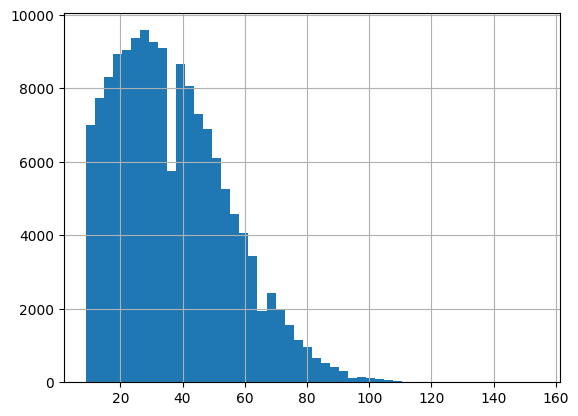

In [7]:
# Univariate analysis example: Distribution of 'purchase_value'
fraud_data['purchase_value'].hist(bins=50)

# Univariate analysis for credit card data: transaction amount
creditcard_data['Amount'].describe()

##### Bivariate Analysis:

                 user_id  purchase_value       age     class
user_id         1.000000        0.002617  0.000611  0.001945
purchase_value  0.002617        1.000000  0.002370  0.001011
age             0.000611        0.002370  1.000000  0.006624
class           0.001945        0.001011  0.006624  1.000000


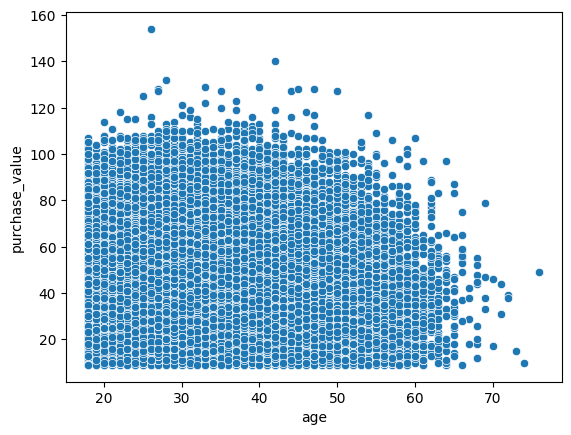

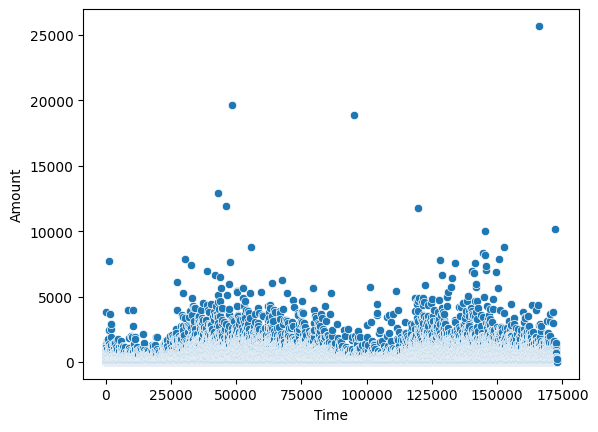

In [11]:
# Remove non-numeric columns for correlation matrix calculation
numeric_fraud_data = fraud_data.select_dtypes(include=['number'])
fraud_corr = numeric_fraud_data.corr()

# Print the correlation matrix
print(fraud_corr)

# Ensure 'age' and 'purchase_value' are available and convert them to numeric
if 'age' in fraud_data.columns and 'purchase_value' in fraud_data.columns:
    fraud_data['age'] = pd.to_numeric(fraud_data['age'], errors='coerce')
    fraud_data['purchase_value'] = pd.to_numeric(fraud_data['purchase_value'], errors='coerce')

    # Create scatter plot
    sns.scatterplot(data=fraud_data, x='age', y='purchase_value')
    plt.show()  # Display the plot
else:
    print("Columns 'age' or 'purchase_value' not found in fraud_data.")

# Ensure 'Time' and 'Amount' are present and convert them to numeric
if 'Time' in creditcard_data.columns and 'Amount' in creditcard_data.columns:
    creditcard_data['Time'] = pd.to_numeric(creditcard_data['Time'], errors='coerce')
    creditcard_data['Amount'] = pd.to_numeric(creditcard_data['Amount'], errors='coerce')

    # Create scatter plot
    sns.scatterplot(data=creditcard_data, x='Time', y='Amount')
    plt.show()  # Display the plot
else:
    print("Columns 'Time' or 'Amount' not found in creditcard_data.")

#### 3. Merge datasets for geolocation analysis

##### Convert IP Addresses to Integer Format:

In [14]:
# Function to check if an IP address is valid
def is_valid_ipv4(ip):
    try:
        ipaddress.IPv4Address(ip)
        return True
    except ipaddress.AddressValueError:
        return False

# Apply the function to filter out invalid IP addresses
valid_ip_mask = fraud_data['ip_address'].apply(is_valid_ipv4)
valid_fraud_data = fraud_data[valid_ip_mask]

# Convert valid IP addresses to integers
valid_fraud_data['ip_address_int'] = valid_fraud_data['ip_address'].apply(lambda x: int(ipaddress.IPv4Address(x)))

# Print a message about how many invalid IPs were found
invalid_ip_count = len(fraud_data) - len(valid_fraud_data)
print(f"Found {invalid_ip_count} invalid IP addresses, removed from dataset.")

Found 151112 invalid IP addresses, removed from dataset.


##### Merge Fraud Data with IP Geolocation Data:

In [16]:
# Ensure both columns are numeric (integers)
fraud_data['ip_address'] = fraud_data['ip_address'].astype(float).astype(int)
ip_data['lower_bound_ip_address'] = ip_data['lower_bound_ip_address'].astype(float).astype(int)

# Perform the merge
fraud_data_clean = pd.merge_asof(fraud_data.sort_values('ip_address'),
                                 ip_data.sort_values('lower_bound_ip_address'),
                                 left_on='ip_address',
                                 right_on='lower_bound_ip_address')

#### 4. Feature Engineering

##### Transaction frequency for Fraud_Data.csv

In [18]:
fraud_data['transaction_freq'] = fraud_data.groupby('user_id')['purchase_time'].transform('count')

##### Time-based features

In [19]:
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.weekday

#### 5. Normalization and Scaling

In [14]:
scaler = StandardScaler()
creditcard_data[['Amount']] = scaler.fit_transform(creditcard_data[['Amount']])

#### 6. Encode categorical features

In [15]:
fraud_data = pd.get_dummies(fraud_data, columns=['source', 'browser', 'sex'], drop_first=True)